In [1]:
import matplotlib.pyplot as plt
import numpy as np

import base.geometry.transformations as T
from data.tools import zed

%matplotlib notebook

In [2]:
uri = 'chum://vh6_b_sim@1234567889.999998976-1234567931.909998994?i=$empty,/mnt/nautilus_rw/tmp/ACjshdfsdf5482&v=sim3d'

In [3]:
reader = zed.from_chum(uri, topics=['/hero_smooth_state', '/vehicle/measurements', '/driving/mofo/imu', '/emu/imu0'])
hss = reader.hero_smooth_state[:]
t = hss.pose.time.nanoseconds.astype('float64') * 1e-9

# Keep only the individual timestamps for the wheel speed measurements
dynamics = reader.vehicle_measurements[:].dynamics
wst, idx = np.unique(dynamics.time_stamp_wheel_speeds, return_index=True)
wst = wst.astype('float64') * 1e-9
vws = (dynamics.wheel_speeds.se[idx] + dynamics.wheel_speeds.sw[idx]) / 2

INFO:absl:Processing input...
INFO:absl:Loading 41.910000018 seconds of data.
INFO:absl:URI:
    vehicle: "vh6_b_sim"
    start_time_ns: 1234567889999998976
    end_time_ns: 1234567931909998994
    start_time_format: kSecondsSinceEpoch
    end_time_format: kSecondsSinceEpoch
    input: "$empty"
    input: "/mnt/nautilus_rw/tmp/ACjshdfsdf5482"
    variant: "sim3d"
    
INFO:absl:Loading data for topic `/driving/mofo/imu` into attribute `driving_mofo_imu`
INFO:absl:Loading data for topic `/emu/imu0` into attribute `emu_imu0`
INFO:absl:Loading data for topic `/hero_smooth_state` into attribute `hero_smooth_state`
INFO:absl:Loading data for topic `/vehicle/measurements` into attribute `vehicle_measurements`


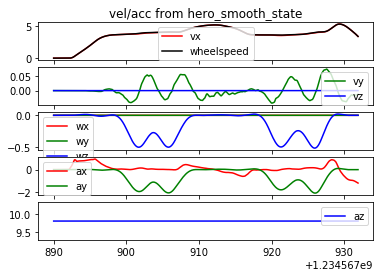

In [4]:
# Plot the vels and accs from the hero smooth state, and wheel speed

ax = plt.subplot(511)
plt.plot(t, hss.body_velocity.v_x, 'r', label='vx')
plt.plot(wst, vws, 'k', label='wheelspeed')
plt.legend()
plt.title('vel/acc from hero_smooth_state')
plt.subplot(512, sharex=ax)
plt.plot(t, hss.body_velocity.v_y, 'g', label='vy')
plt.plot(t, hss.body_velocity.v_z, 'b', label='vz')
plt.legend()
plt.subplot(513, sharex=ax)
plt.plot(t, hss.body_velocity.w_x, 'r', label='wx')
plt.plot(t, hss.body_velocity.w_y, 'g', label='wy')
plt.plot(t, hss.body_velocity.w_z, 'b', label='wz')
plt.legend()
plt.subplot(514, sharex=ax)
plt.plot(t, hss.body_acceleration.a_x, 'r', label='ax')
plt.plot(t, hss.body_acceleration.a_y, 'g', label='ay')
plt.legend()
plt.subplot(515, sharex=ax)
plt.plot(t, hss.body_acceleration.a_z, 'b', label='az')
plt.legend()

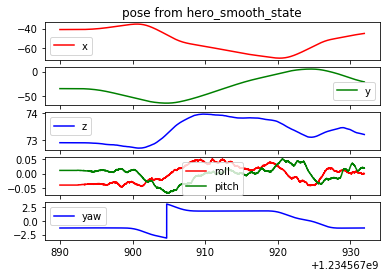

In [5]:
# Plot the hero smooth pose

ax = plt.subplot(511, sharex=ax)
plt.plot(t, hss.pose.x, 'r', label='x')
plt.legend()
plt.title('pose from hero_smooth_state')
plt.subplot(512, sharex=ax)
plt.plot(t, hss.pose.y, 'g', label='y')
plt.legend()
plt.subplot(513, sharex=ax)
plt.plot(t, hss.pose.z, 'b', label='z')
plt.legend()
plt.subplot(514, sharex=ax)
plt.plot(t, hss.pose.roll, 'r', label='roll')
plt.plot(t, hss.pose.pitch, 'g', label='pitch')
plt.legend()
plt.subplot(515, sharex=ax)
plt.plot(t, hss.pose.yaw, 'b', label='yaw')
plt.legend()

In [6]:
# Compute vel and acc by differentiating the pose:

p = np.column_stack((hss.pose.x, hss.pose.y, hss.pose.z, hss.pose.roll, hss.pose.pitch, hss.pose.yaw))
dp = np.diff(p, axis=0)

# take care of yaw wrapping around 360:
sel = (np.abs(dp[:, 5]) > 3).nonzero()[0]
dp[sel, 5] = dp[sel-1, 5]

v_w = np.column_stack([np.divide(dp[:, i], np.diff(t)) for i in range(6)])
vt = t[1:]
dv = np.diff(v_w, axis=0)
a_w = np.column_stack([np.divide(dv[:, i], np.diff(vt)) for i in range(3)])
at = vt[1:]

# Rotate from world frame to body frame:
vb = np.zeros_like(v_w)
ab = np.zeros_like(a_w)
for i in range(1, len(hss)):
    M = T.euler_matrix(hss.pose.roll[i], hss.pose.pitch[i], hss.pose.yaw[i], axes='sxyz')[:3, :3]
    vb[i-1, :3] = np.dot(M.T, v_w[i-1, :3])
    vb[i-1, 3:6] = np.dot(M.T, v_w[i-1, 3:6])
    if i > 1:
        ab[i-2, :3] = np.dot(M.T, a_w[i-2, :3])

# longitudinal acceleration from wheel speed
a_x_wss = np.divide(np.diff(vws), np.diff(wst))
a_x_wss_t = wst[1:]

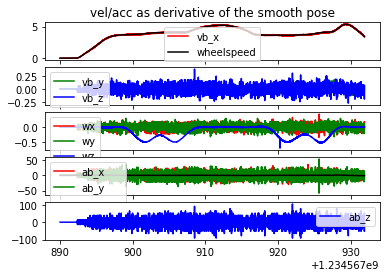

In [7]:
ax = plt.subplot(511)
plt.plot(vt, vb[:, 0], 'r', label='vb_x')
plt.plot(wst, vws, 'k', label='wheelspeed')
plt.legend()
plt.title('vel/acc as derivative of the smooth pose')
plt.subplot(512, sharex=ax)
plt.plot(vt, vb[:, 1], 'g', label='vb_y')
plt.plot(vt, vb[:, 2], 'b', label='vb_z')
plt.legend()
plt.subplot(513, sharex=ax)
plt.plot(vt, vb[:, 3], 'r', label='wx')
plt.plot(vt, vb[:, 4], 'g', label='wy')
plt.plot(vt, vb[:, 5], 'b', label='wz')
plt.legend()
plt.subplot(514, sharex=ax)
plt.plot(at, ab[:, 0], 'r', label='ab_x')
plt.plot(at, ab[:, 1], 'g', label='ab_y')
plt.plot(a_x_wss_t, a_x_wss, 'k', label='a_x_wss')
plt.legend()
plt.subplot(515, sharex=ax)
plt.plot(at, ab[:, 2], 'b', label='ab_z')
plt.legend()

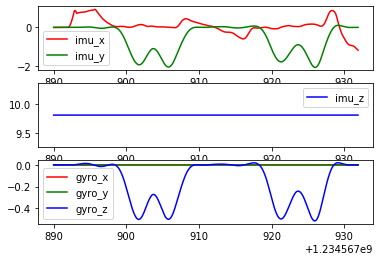

In [8]:
if reader.driving_mofo_imu or reader.emu_imu0:
    if reader.driving_mofo_imu:
        imu = reader.driving_mofo_imu[:]
    elif reader.emu_imu0:
        imu = reader.emu_imu0[:]
    imu_t = imu.header.stamp.secs.astype('float64') + imu.header.stamp.nsecs.astype('float64') * 1e-9
    plt.figure()
    ax = plt.subplot(311)
    plt.plot(imu_t, imu.linear_acceleration.x, 'r', label='imu_x')
    plt.plot(imu_t, imu.linear_acceleration.y, 'g', label='imu_y')
    plt.legend()
    plt.subplot(312, sharex=ax)
    plt.plot(imu_t, imu.linear_acceleration.z, 'b', label='imu_z')
    plt.legend()
    plt.subplot(313, sharex=ax)
    plt.plot(imu_t, imu.angular_velocity.x, 'r', label='gyro_x')
    plt.plot(imu_t, imu.angular_velocity.y, 'g', label='gyro_y')
    plt.plot(imu_t, imu.angular_velocity.z, 'b', label='gyro_z')
    plt.legend()